# Align the Beaded Helix using shapeGMMTorch libraries

In this notebook I will demonstrate how to perform a single maximum likelihood alignment of a trajectory using the shapeGMMTorch libraries.  I will do this for both uniform and kronecker covariance models.

I will use MDAnalysis to read the trajectory but any way of reading a trajectory and generating a `(n_frames, n_atoms, 3)` array is fine.

## Import Libraries

In [5]:
import sys
import numpy as np
# we will use MDAnalysis to read trajectory
import MDAnalysis as md
# the alignment routines are contained in torch_align
from shapeGMMTorch import torch_align
# we will also need to load pytorch to prepare the data
import torch
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Read trajectory

In [4]:
prmtopFileName = "../beaded_helix_example/helix_template.pdb"
trajFileName = "../beaded_helix_example/helix_folding_eps6.0.dcd"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
traj_numpy = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    traj_numpy[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 10001
Number of atoms in selection: 12


## Convert trajectory to a torch tensor and substract center of geometry

In [6]:
# for torch we need to declare the device to perform operation
device = torch.device("cpu")
dtype = torch.float32

In [7]:
# create torch tensor
traj_tensor = torch.tensor(traj_numpy,device=device,dtype=dtype)
# remove COG
torch_align.torch_remove_center_of_geometry(traj_tensor)

## Uniform alignment

Below I will perform a uniform alignment.  The alignment routine takes in and returns torch tensors.  The routine returns the aligned positions, average, and variance.  If you put `verbose=True` the routine will print the log likelihood of each iteration.

In [8]:
uniform_aligned_traj_tensor, uniform_avg_tensor, uniform_var_tensor = torch_align.torch_iterative_align_uniform(traj_tensor, device=device, dtype=dtype, verbose=True)

14.103167715892111
15.653984409911542
15.699899158017994
15.716427872375503
15.725605117749549
15.730752390271883
15.733637576830931
15.735245252710037
15.736138815441734


In [12]:
# pass tensor back to cpu/numpy
uniform_aligned_traj_numpy = uniform_aligned_traj_tensor.cpu().numpy()
uniform_aligned_avg_numpy = uniform_avg_tensor.cpu().numpy()

## Kronecker alignment

In [10]:
kronecker_aligned_traj_tensor, kronecker_avg_tensor, kronecker_precision_tensor, kronecker_lpdet_tensor = torch_align.torch_iterative_align_kronecker(traj_tensor, device=device, dtype=dtype, verbose=True)

48.582760834177684
51.03444437961713
51.346624956806174
51.50211735335196
51.62553682130644
51.74200300342535
51.85588663171645
51.95696304142575
52.03281291207417
52.08529018883732
52.11929445488368
52.14029357663823
52.153006365991644
52.16067568065209
52.165332505737936
52.16819869777056
52.16999757075537
52.171157031433054
52.17193001152688


In [13]:
kronecker_aligned_traj_numpy = kronecker_aligned_traj_tensor.cpu().numpy()
kronecker_aligned_avg_numpy = kronecker_avg_tensor.cpu().numpy()

# Compare and contrast RMSFs

In [31]:
# calculate RMSF for uniform 
uniform_disp = uniform_aligned_traj_numpy-uniform_aligned_avg_numpy
uniform_disp = np.transpose(uniform_disp,axes=(1,0,2))
uniform_disp = uniform_disp.reshape((-1,uniform_disp.shape[1]*uniform_disp.shape[2]))
uniform_NxN_covar = np.dot(uniform_disp,uniform_disp.T)/(uniform_aligned_traj_numpy.shape[0]-1)
uniform_rmsf = np.sqrt(np.diagonal(uniform_NxN_covar))
# calculate RMSF for uniform 
kronecker_disp = kronecker_aligned_traj_numpy-kronecker_aligned_avg_numpy
kronecker_disp = np.transpose(kronecker_disp,axes=(1,0,2))
kronecker_disp = kronecker_disp.reshape((-1,kronecker_disp.shape[1]*kronecker_disp.shape[2]))
kronecker_NxN_covar = np.dot(kronecker_disp,kronecker_disp.T)/(kronecker_aligned_traj_numpy.shape[0]-1)
kronecker_rmsf = np.sqrt(np.diagonal(kronecker_NxN_covar))

In [32]:
# The NxN covar is readily calculated for Kronecker alignmnet from the pseudo inverse of the returned precision matrix
from shapeGMMTorch import scripts
kronecker_rmsf_2 = np.sqrt(np.diagonal(scripts._pinv(kronecker_precision_tensor.cpu().numpy())*3))

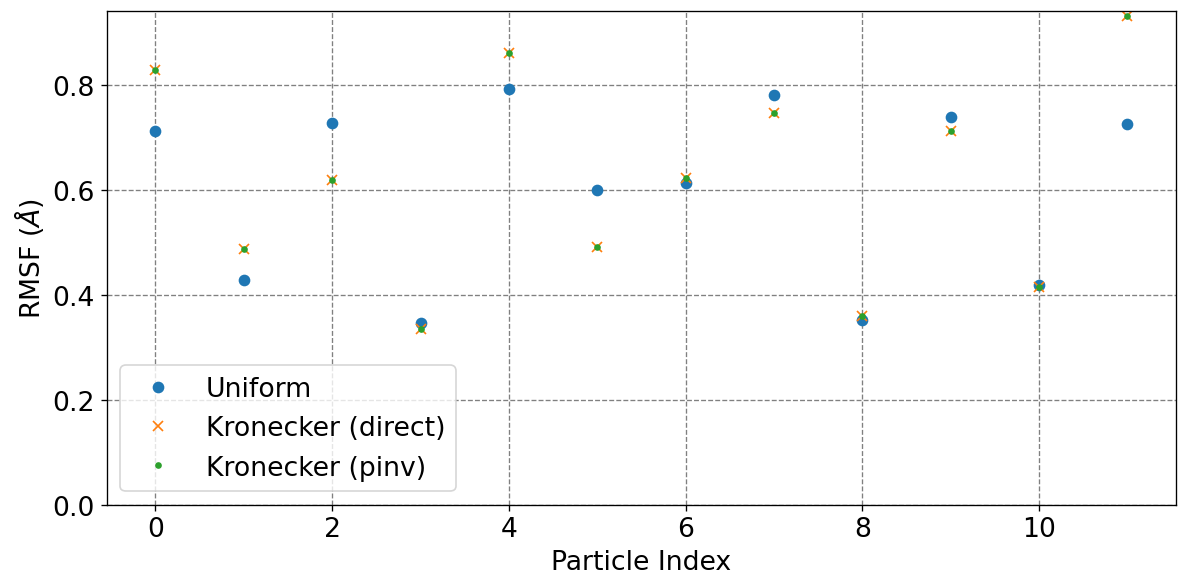

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
# create figure
plt.figure(figsize=(10,5), dpi= 120, facecolor='w', edgecolor='k')
# plot data
plt.plot(uniform_rmsf,'o',label="Uniform")
plt.plot(kronecker_rmsf,'x',label="Kronecker (direct)")
plt.plot(kronecker_rmsf,'.',label="Kronecker (pinv)")
# format plot 
plt.grid(which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel(r"RMSF ($\AA$)",fontsize=16)
plt.xlabel("Particle Index",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.legend(fontsize=16)
plt.ylim(0,0.94)
plt.tight_layout()